# Error Mitigation Using Zero Noise Extrapolation

In this tutorial we attempt to reproduce figure 2(a) of [Kandala et al](https://arxiv.org/pdf/1805.04492.pdf). We plot the expectation value and the zero noise limit of the ground state projector $| 0 \rangle \langle 0|$ for a single qubit, under a circuit consisting of sequences of idenitity equivalent Clifford operations in the presence of depolarizing noise. The circuit is of the form 
$$ U = U_1 U_2 \cdots U_n,$$
where each $U_i$ is given by
$$U_i = \sigma_1 \sigma_2 \sigma_2 \sigma_1$$
and $\sigma_1, \sigma_2$ are chosen randomly from $[X, Y, Z]$. The exact expectation value is then simply 1.0.

We beging by defining a function that takes a circuit, in this case a Cirq circuit, and appends a random sequence of Clifford operations.

In [1]:
import random
from cirq import Circuit, LineQubit, H, X, Y, Z, I

def extend_circuit(circuit: Circuit) -> Circuit:
    """
    Extends a circuit with a sequence of Clifford operations of the form:
                    U = σ1*σ2*σ2*σ1,
    where σ1 and σ2 are randomly chosen from [X, Y, Z].
    The final circuit is then equivalent to the identity.
    """

    qubit = LineQubit(0)
    
    paulis = {1: "X", 2: "Y", 3: "Z"}
    pauli1 = random.choice(list(paulis.keys()))
    pauli2 = random.choice(list(paulis.keys()))
    
    gate_sequence = [pauli1, pauli2, pauli2, pauli1]

    for pauli in gate_sequence:
        if paulis[pauli] == "X":
            circuit.append(X(qubit))
        elif paulis[pauli] == "Y":
            circuit.append(Y(qubit))
        else:
            circuit.append(Z(qubit))
    return circuit      

Next we define our density matrix simulator. It returns the expectation value of the ground state projector in the presence of depolarizing noise. 

In [7]:
import numpy as np
from cirq import depolarize, DensityMatrixSimulator

# initialize a backend
SIMULATOR = DensityMatrixSimulator()
# 1% depolarizing noise
NOISE = 0.01

def executor(circ: Circuit) -> float:
    """
    Executes a circuit with depolarizing noise and
    returns the expectation value of the projector |0><0|.
    """

    circuit = circ.with_noise(depolarize(p=NOISE))
    rho = SIMULATOR.simulate(circuit).final_density_matrix
    obs = np.diag([1, 0])
    expectation = np.real(np.trace(rho @ obs))
    return expectation

For each scale factor $c_i \in \{1.0, 2.0, 3.0, 4.0\}$ we need to calculate the expectation value. We do this here by globally folding the circuit. Then we calculate the zero noise limit expectation value using third order Richardson extrapolation. Note that in the paper they also calcualte the first and second order extrapolation values.

In [8]:
from mitiq.zne.scaling import fold_global
from mitiq.zne.zne import execute_with_zne
from mitiq.zne.inference import RichardsonFactory

def get_expvals(circuit, scale_factors = [1.0, 2.0, 3.0, 4.0]):
    """
    Calculates the expectation value of the projector |0><0|
    of the circuit for each scale factor in scale_factors.
    In addition, the zero noise limit is calculated using
    Richardson extrapolation.
    """

    richardson_factory = RichardsonFactory(scale_factors)
    real_expvals = []

    for scale_factor in scale_factors:
        folded_circuit = fold_global(circuit, scale_factor)
        expval = executor(folded_circuit)
        real_expvals.append(expval)

    zne_limit = execute_with_zne(circuit, executor, factory=richardson_factory)
    return real_expvals, zne_limit

We define a function to run our simulation an $n$ number of times.

In [ ]:
def simulation(n, scale_factors = [1.0, 2.0, 3.0, 4.0]):
    """
    Runs get_expvals() n times to get the expected value and
    zero noise limit. Every run the circuit is extended by
    a sequence of 4 Pauli operators (extend_circuit()) equivalent
    to the identity. Thus in every run k the number of Paulis in the
    ciruit is 4k.
    """
    
    expvals = {scale_factor: [] for scale_factor in scale_factors}
    zne_limit_vals = []
    qubit = LineQubit(0)
    circuit = Circuit(I(qubit))
    
    for _ in range(n):
        circuit = extend_circuit(circuit)
        real_expvals, zne_limit = get_expvals(circuit, scale_factors)
        
        for idx, scale in enumerate(scale_factors):
            expvals[scale].append(real_expvals[idx])

        zne_limit_vals.append(zne_limit)
    return expvals, zne_limit_vals

We run the simulation for $n=75$, and scale factors $c_i \in \{1.0, 2.0, 3.0, 4.0\}$. The final circuit thus consists of $300$ Pauli gates.

In [9]:
n = 75
scale_factors = [1.0, 2.0, 3.0, 4.0]
expvals, zne_limit_vals = run_simulation(n, scale_factors)

We plot the results.

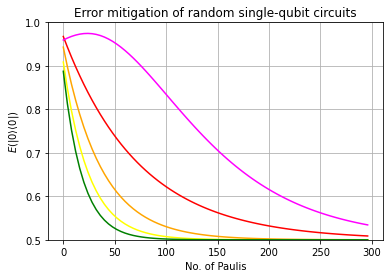

In [32]:
c1 = expvals[1.0] 
c2 = expvals[2.0]
c3 = expvals[3.0]
c4 = expvals[4.0]

num_cliffords = [4*i for i in range(n)]

import matplotlib.pyplot as plt

plt.title('Error mitigation of random single-qubit circuits')
plt.xlabel('No. of Paulis') 
plt.ylabel(r'$E(| 0 \rangle \langle 0|)$')
plt.grid(True)
plt.ylim((0.5, 1.0));

plt.plot(num_cliffords, c1, 'red')
plt.plot(num_cliffords, c2, 'orange')
plt.plot(num_cliffords, c3, 'yellow')
plt.plot(num_cliffords, c4, 'green')
plt.plot(num_cliffords, zne_limit_vals, 'magenta')
plt.show()